<div style="color:#B3093F; font-size:150%; text-align:left; border-radius:5px">
    <h4><u> BIBLIOTECAS UTILIZADAS </u></h4>
</div>

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

<div style="color:#B3093F; font-size:150%; text-align:left; border-radius:5px">
    <h4><u> IMPORTAR DADOS </u></h4>
</div>

In [2]:
df = pd.read_csv('../dados/breast_cancer_bd.csv', sep=',')
display(df[:3])

,Sample code number,Clump Thickness,Keseragaman Ukuran Sel,Keseragaman Bentuk Sel,Pertumbuhan Sel,Ukuran Sel Epitel Tunggal,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2


In [3]:
print('\nA base de dados possui {} linhas e {} colunas.'.format(df.shape[0], df.shape[1]))


A base de dados possui 699 linhas e 11 colunas.


**Podemos observar que nossos dados contêm:**
- **1 variável dependente (alvo) 'Class';**
<br>
<br>
- **10 varíaveis independentes sendo que, em 'Sample code number' temos apenas o ID do paciente.**

<div style="color:#B3093F; font-size:150%; text-align:left; border-radius:5px">
    <h4><u> TRATAR DADOS </u></h4>
</div>

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Sample code number           699 non-null    int64 
 1   Clump Thickness              699 non-null    int64 
 2   Keseragaman Ukuran Sel      699 non-null    int64 
 3   Keseragaman Bentuk Sel     699 non-null    int64 
 4   Pertumbuhan Sel            699 non-null    int64 
 5   Ukuran Sel Epitel Tunggal  699 non-null    int64 
 6   Bare Nuclei                  699 non-null    object
 7   Bland Chromatin              699 non-null    int64 
 8   Normal Nucleoli              699 non-null    int64 
 9   Mitoses                      699 non-null    int64 
 10  Class                        699 non-null    int64 
dtypes: int64(10), object(1)
memory usage: 60.2+ KB


In [5]:
print(f"\nTipo de dado em Bare Nuclei: {df['Bare Nuclei'].dtype}")
print(f"\nValores contidos em Bare Nuclei: {df['Bare Nuclei'].unique()}")


Tipo de dado em Bare Nuclei: object

Valores contidos em Bare Nuclei: ['1' '10' '2' '4' '3' '9' '7' '?' '5' '8' '6']


**Existe um problema na variável 'Bare Nuclei', seu Dtype deveria ser int64 assim como os demais porém, está classificado como object devido a dados faltantes inseridos no banco de dados com o carácter '?'.** 
<br>
<br>
**Por isso corrigiremos:**

In [6]:
df['Bare Nuclei'] = df['Bare Nuclei'].replace('?', np.NaN)
df['Bare Nuclei'] = pd.to_numeric(df['Bare Nuclei'])

print(f"\nBare Nuclei agora contém {df['Bare Nuclei'].isna().sum()} valores faltantes")
print(f"\nValores contidos em Bare Nuclei: {df['Bare Nuclei'].unique()}")
print(f"\nTipo de dado em Bare Nuclei: {df['Bare Nuclei'].dtype}")


Bare Nuclei agora contém 16 valores faltantes

Valores contidos em Bare Nuclei: [ 1. 10.  2.  4.  3.  9.  7. nan  5.  8.  6.]

Tipo de dado em Bare Nuclei: float64


**Todos os valores '?' foram apagados, analisaremos agora como preencher estes 16 valores faltantes:**

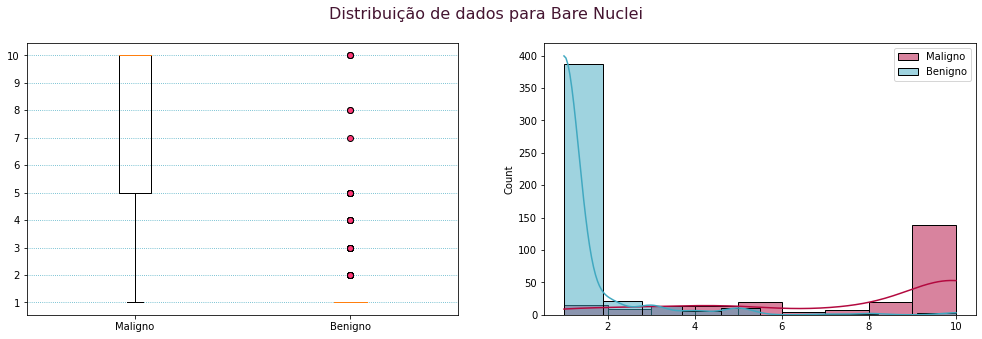

In [7]:
df_class2 = df[df['Class'] == 2]
df_class4 = df[df['Class'] == 4]


fig, ax = plt.subplots(1,2 , figsize=(17, 5))
fig.suptitle('Distribuição de dados para Bare Nuclei', fontsize=16, color='#451531')

data = [df_class4['Bare Nuclei'].dropna(), df_class2['Bare Nuclei'].dropna()]
ax[0].boxplot(data, labels=['Maligno', 'Benigno'], flierprops={'markerfacecolor':'#FF3877'})
ax[0].grid(axis='y',linestyle='dotted', color='#40A8C0')
ax[0].set_yticks(list(range(1,11)))

sns.histplot(ax=ax[1], data=df_class4['Bare Nuclei'], kde=True, color='#B3093F', label='Maligno')
sns.histplot(ax=ax[1], data=df_class2['Bare Nuclei'], kde=True, color='#40A8C0', label='Benigno')
ax[1].set_xlabel('')

plt.legend()
plt.show()

**Como o valor do 'Bare Nuclei' depende muito da classificação do tumor, adotaremos a mediana dos valores do grupo. Ou seja, para pacientes que estão sem este diagnóstico será assumido o valor da mediana do seu grupo de classificação.**  

In [8]:
df_class2 = df_class2.fillna(df_class2['Bare Nuclei'].median())
df_class4 = df_class4.fillna(df_class4['Bare Nuclei'].median())

df = pd.concat([df_class2, df_class4]).sort_index().set_index('Sample code number')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 699 entries, 1000025 to 897471
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Clump Thickness              699 non-null    int64  
 1   Keseragaman Ukuran Sel      699 non-null    int64  
 2   Keseragaman Bentuk Sel     699 non-null    int64  
 3   Pertumbuhan Sel            699 non-null    int64  
 4   Ukuran Sel Epitel Tunggal  699 non-null    int64  
 5   Bare Nuclei                  699 non-null    float64
 6   Bland Chromatin              699 non-null    int64  
 7   Normal Nucleoli              699 non-null    int64  
 8   Mitoses                      699 non-null    int64  
 9   Class                        699 non-null    int64  
dtypes: float64(1), int64(9)
memory usage: 60.1 KB


**Agora já temos nosso banco de dados tratado.**

<div style="color:#B3093F; font-size:150%; text-align:left; border-radius:5px">
    <h4><u> EXPLORAR DADOS </u></h4>
</div>

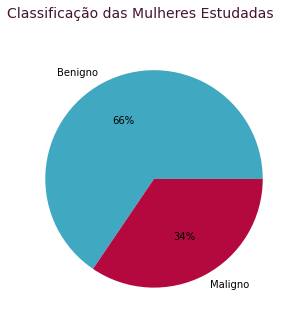

In [9]:
fig, ax = plt.subplots(figsize=(15,5))
fig.suptitle('Classificação das Mulheres Estudadas', fontsize=14, color='#451531',)

ax.pie(x=df['Class'].value_counts().values, 
        labels = ['Benigno', 'Maligno'], colors = ['#40A8C0', '#B3093F'], autopct='%.0f%%')

plt.show()

**Para termos uma breve visualização das informações contidas em cada característica, plotaremos dois gráficos para cada variável, assim ficará mais visível a distribuição dos dados em cada grupo de pacientes:**

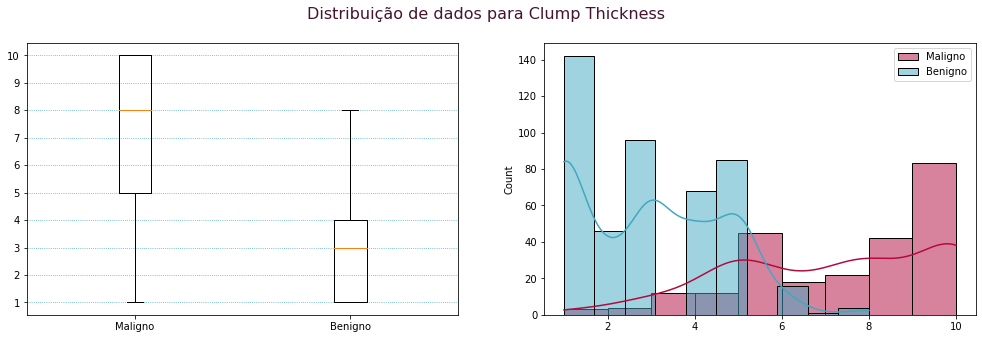

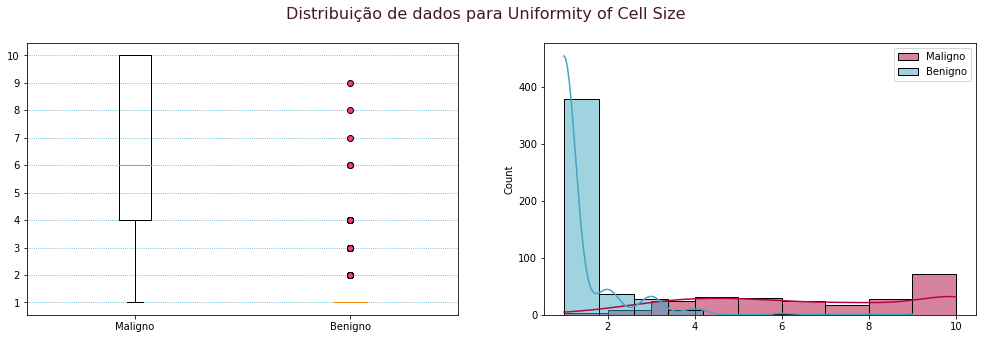

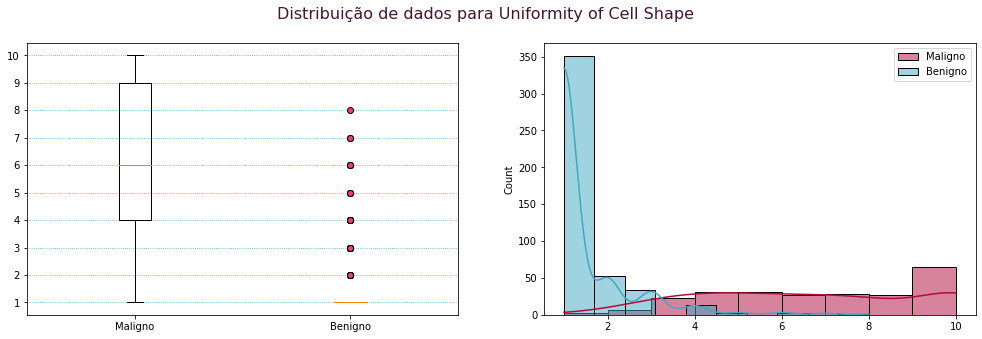

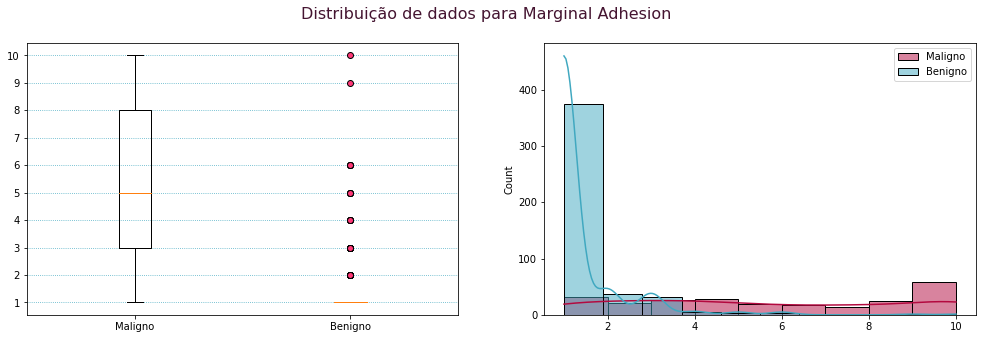

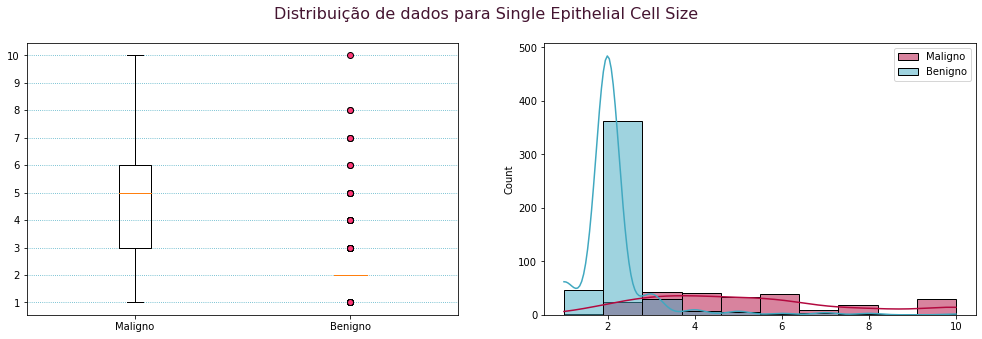

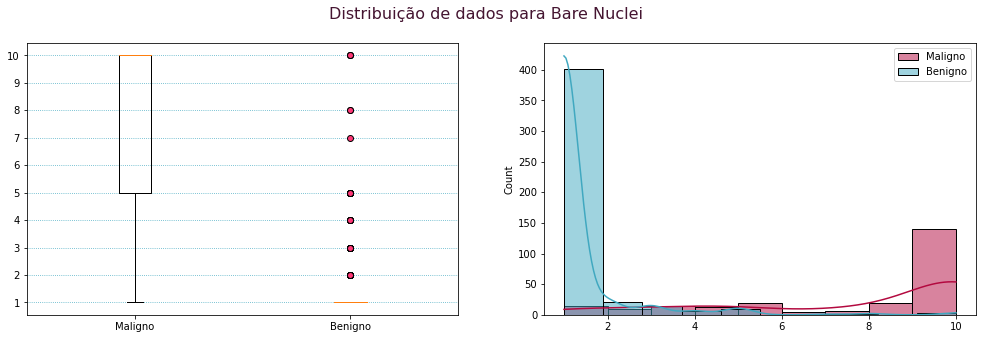

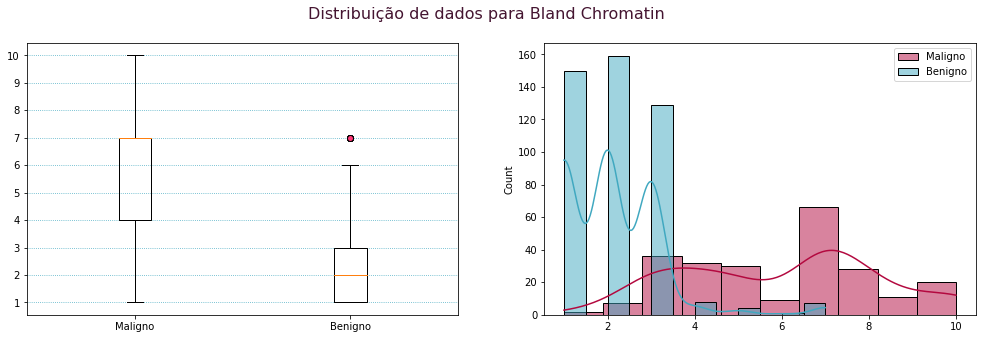

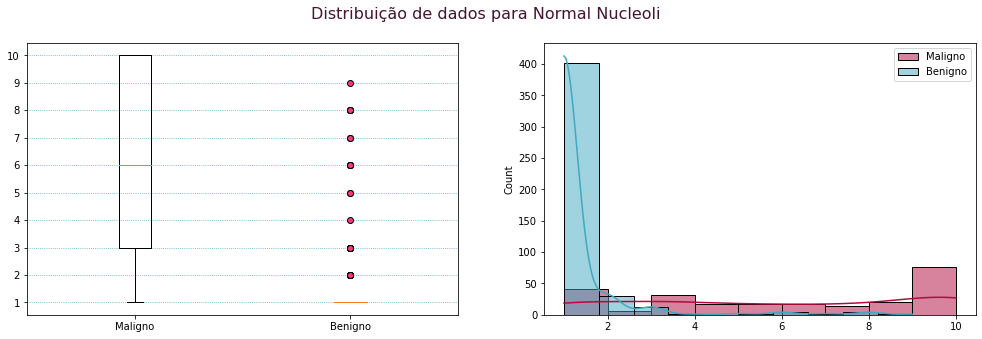

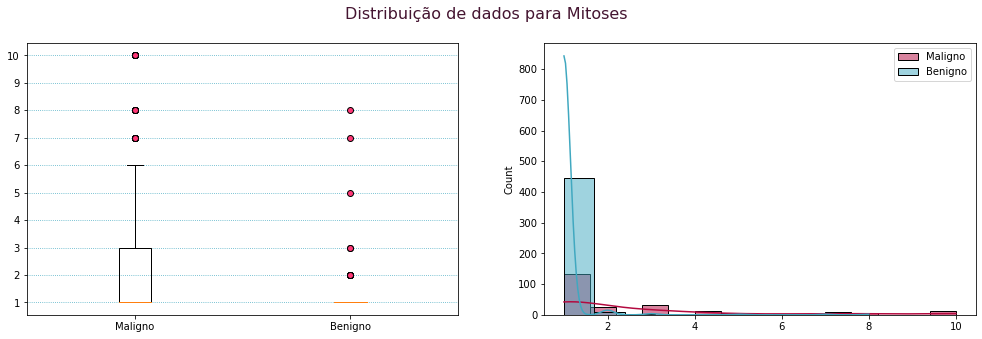

In [10]:
df_class2 = df[df['Class'] == 2]
df_class4 = df[df['Class'] == 4]

for colum in df.drop('Class', axis=1).columns:
    fig, ax = plt.subplots(1,2 , figsize=(17, 5))
    fig.suptitle(f'Distribuição de dados para {colum}', fontsize=16, color='#451531')

    data = [df_class4[colum].dropna(), df_class2[colum].dropna()]
    ax[0].boxplot(data, labels=['Maligno', 'Benigno'], flierprops={'markerfacecolor':'#FF3877'})
    ax[0].grid(axis='y',linestyle='dotted', color='#40A8C0')
    ax[0].set_yticks(list(range(1,11)))

    sns.histplot(ax=ax[1], data=df_class4[colum], kde=True, color='#B3093F', label='Maligno')
    sns.histplot(ax=ax[1], data=df_class2[colum], kde=True, color='#40A8C0', label='Benigno')
    ax[1].set_xlabel('')

    plt.legend()
    plt.show()

**Aqui já fica nítido a diferença de cada diagnóstico em cada grupo de mulheres. Todos nossos dados estão em uma escala que vai de 1 a 10. No grupo de pacientes com tumor maligno o seu resultado médio é maior em todas as características observadas.**
<br>
<br>
**Para completar a análise, vamos verificar a correlação individual de cada característica com a classificação do tumor em um mapa de calor:**

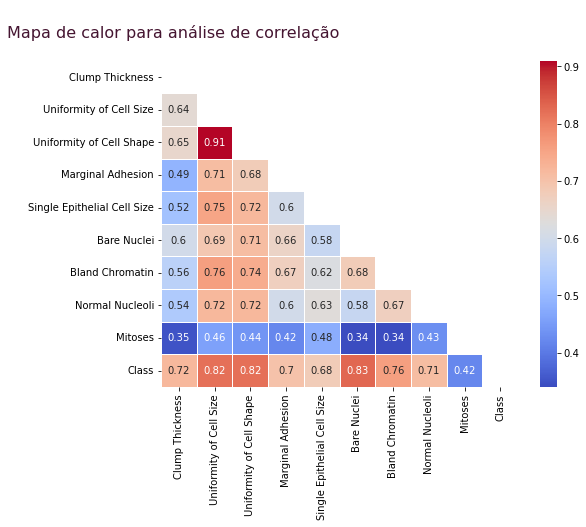

In [11]:
data = df.corr()

plt.figure(figsize=(8,6))

mask = np.zeros_like(data)
mask[np.triu_indices_from(mask)] = True

plt.title('\nMapa de calor para análise de correlação\n', fontsize=16, color='#451531', ha='right')
sns.heatmap(data=data.round(2), mask=mask, annot=True, fmt= '.2', cmap='coolwarm', linewidths=.7)

plt.show()

**Podemos observar que a escolha das características foi minuciosa para a realização de um bom diagnóstico. A maioria delas possuem uma correlação consideravelmente forte com a classificação do tumor e, comprovando o visualizado anteriormente, um valor mais alto nos resultados de cada exame, influenciam positivamente a aparição de um tumor maligno.**

<div style="color:#B3093F; font-size:150%; text-align:left; border-radius:5px">
    <h4><u> CRIAR MODELO PREDITIVO </u></h4>
</div>

**Terminada a exploração dos dados, já temos agora informações suficientes para desenvolvimento de um modelo de aprendizado supervisionado para identificação dos tumores, classificando-os em maligno ou benigno.**
<br>
<br>
**Vamos preparar os dados para criação do modelo. Inicialmente separaremos os dados para teste, treino e validação em variáveis independentes (x) e variável dependente (y) e, após, balancearemos os dados.**
<br>
<br>
**Separar e Balancear os Dados:**

In [12]:
x = df.drop('Class', axis=1)
y = df['Class']

x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, test_size=0.3, random_state=1)
x_val, x_teste, y_val, y_teste = train_test_split(x_teste, y_teste, test_size=0.5, random_state=1)

In [13]:
print(f'Tamanho dos Dados de Treino: {len(x_treino)}')
print(f'Tamanho dos Dados de Teste: {len(x_teste)}')
print(f'Tamanho dos Dados de Validação: {len(x_val)}')

Tamanho dos Dados de Treino: 489
Tamanho dos Dados de Teste: 105
Tamanho dos Dados de Validação: 105


**O balanceamento dos dados aqui visa equilibrar o número de casos benignos e malignos. Utilizamos aqui de uma técnica para oversampling na base de dados para treino, assim, nosso modelo terá mais dados de treino para identificar as características dos tumores malignos.**

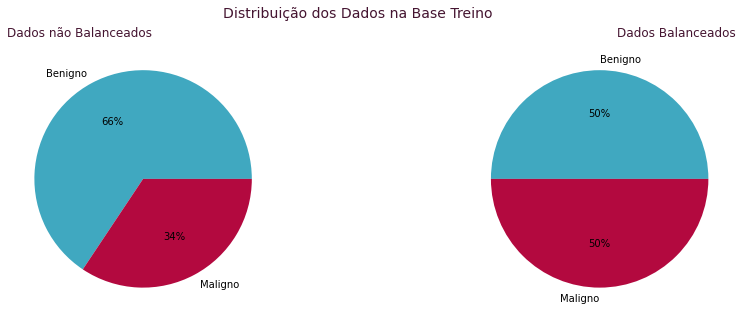

Tamanho dos Dados de Treino Balanceados: 642


In [14]:
balanceamento_over = SMOTE(random_state=1)
x_bal, y_bal = balanceamento_over.fit_resample(x_treino, y_treino)

fig, ax = plt.subplots(1,2, figsize=(15,5))
fig.suptitle('Distribuição dos Dados na Base Treino', fontsize=14, color='#451531')

ax[0].set_title('Dados não Balanceados', fontsize=12, color='#451531', loc='left')
ax[0].pie(x=y_treino.value_counts().values, 
        labels = ['Benigno', 'Maligno'], colors = ['#40A8C0', '#B3093F'], autopct='%.0f%%')

ax[1].set_title('Dados Balanceados', fontsize=12, color='#451531', loc='right')
ax[1].pie(x=y_bal.value_counts().values, 
        labels = ['Benigno', 'Maligno'], colors = ['#40A8C0', '#B3093F'], autopct='%.0f%%')

plt.show()

print(f'Tamanho dos Dados de Treino Balanceados: {len(x_bal)}')

**Para criação do modelo, testaremos inicialmente cinco algoritmos diferentes para escolhermos um que melhor resultado nos entregue. Os algoritmos analisados serão: Random Forest, Suport Vector Machine, Linear Regression, K Neighbor Nearest e Gradient Booster**.
<br>
<br>
**Vamos analisar os resultados obtidos**:

In [15]:
randomforest = RandomForestClassifier(random_state=1)
suportvectormachine = svm.SVC(random_state=1)
regressaologistica = LogisticRegression(random_state=1)
knn = KNeighborsClassifier()
gradientboosting = GradientBoostingClassifier(random_state=1)

modelos_classificacao = {'Random Forest': randomforest, 'Supor Vector Machine': suportvectormachine,
                         'Logistic Regression': regressaologistica, 'K Nearest Neighbor': knn,
                         'Gradient Boosting': gradientboosting}

for nome_modelo, modelo in modelos_classificacao.items():
    modelo.fit(x_bal, y_bal)
    y_pred = modelo.predict(x_teste)
    print(f'\n\nRelatório de Classificação {nome_modelo}:\n\n',classification_report(y_teste, y_pred))



Relatório de Classificação Random Forest:

               precision    recall  f1-score   support

           2       1.00      0.97      0.98        65
           4       0.95      1.00      0.98        40

    accuracy                           0.98       105
   macro avg       0.98      0.98      0.98       105
weighted avg       0.98      0.98      0.98       105



Relatório de Classificação Supor Vector Machine:

               precision    recall  f1-score   support

           2       1.00      0.95      0.98        65
           4       0.93      1.00      0.96        40

    accuracy                           0.97       105
   macro avg       0.97      0.98      0.97       105
weighted avg       0.97      0.97      0.97       105



Relatório de Classificação Logistic Regression:

               precision    recall  f1-score   support

           2       1.00      0.97      0.98        65
           4       0.95      1.00      0.98        40

    accuracy                   

**De um modo geral todos os nossos modelos tiveram resultados satisfatórios.**
<br>
<br>
**Pelo contexto do problema, podemos entender que, o problema mais grave seria a não identificação dos tumores malignos. Este tipo de erro poderia atrasar o início de um tratamento, onde o diagnóstico precoce é de suma importância na cura. Assim, neste caso temos um alto custo dos Falsos Negativos, e uma métrica melhor para esta situação seria o Recall.**
<br>
<br>
**Como nossos modelos foram igualmente bons, combinaremos dois dos melhores avaliados a fim de equilibrar suas fraquezas individuais usando as probabilidades previstas médias para prever o rótulo da classe. Selecionaremos para isso o Random Forest e o K Nearest Neighbor, pois, além de obterem os melhores resultados, são conceitualmente diferentes. Podendo melhorar ainda mais nosso Recall e Acuracidade.**

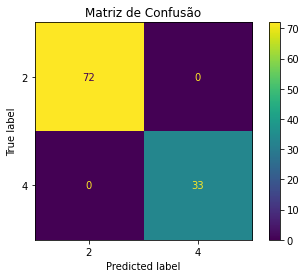

              precision    recall  f1-score   support

           2       1.00      1.00      1.00        72
           4       1.00      1.00      1.00        33

    accuracy                           1.00       105
   macro avg       1.00      1.00      1.00       105
weighted avg       1.00      1.00      1.00       105



In [16]:
modelos_combinados = VotingClassifier(estimators=[('randomforest', randomforest), ('knn', knn)], voting='soft')
modelos_combinados.fit(x_bal, y_bal)
y_pred = modelos_combinados.predict(x_val)
y_pred_prob = modelos_combinados.predict_proba(x_val)

grafico = ConfusionMatrixDisplay(confusion_matrix(y_val, y_pred), display_labels=modelos_combinados.classes_)
grafico.plot()
plt.title('Matriz de Confusão')
plt.show()

print(classification_report(y_val, y_pred))

**Nosso modelo combinado entre Random Forest e K Nearest Neighbor acertou todos os resultados nos nossos dados de validação, ainda desconhecidos pelo modelo.**
<br>
<br>
**Temos aqui então um ótimo modelo de classificação, porém, como se trata de diagnósticos extremamente importantes, é sempre bom avaliar não só o rótulo da classificação, mas também, a probabilidade da ocorrência.**